# Working example of protein strain analysis with data from [Hahn et al, 2018, Science]

## Loading

We begin by loading the polypeptides in two conformation, which for simplicity are called relaxed and deformed structures

In [1]:
import warnings
import psa.load as load
warnings.filterwarnings('ignore')

# Input
rel_pdb, def_pdb = '6FKF', '6FKH'

# Compute
rel_pps = load.single_structure(name = rel_pdb)
def_pps = load.single_structure(name = def_pdb)

## Coordinates loading for visualization

We start by importing the structure for a quick manual inspection. At this point rotations in the reference structure can be applied to set axes orientations

In our case, we simply visualise the structure in the coordenate system adopted in the PDB files

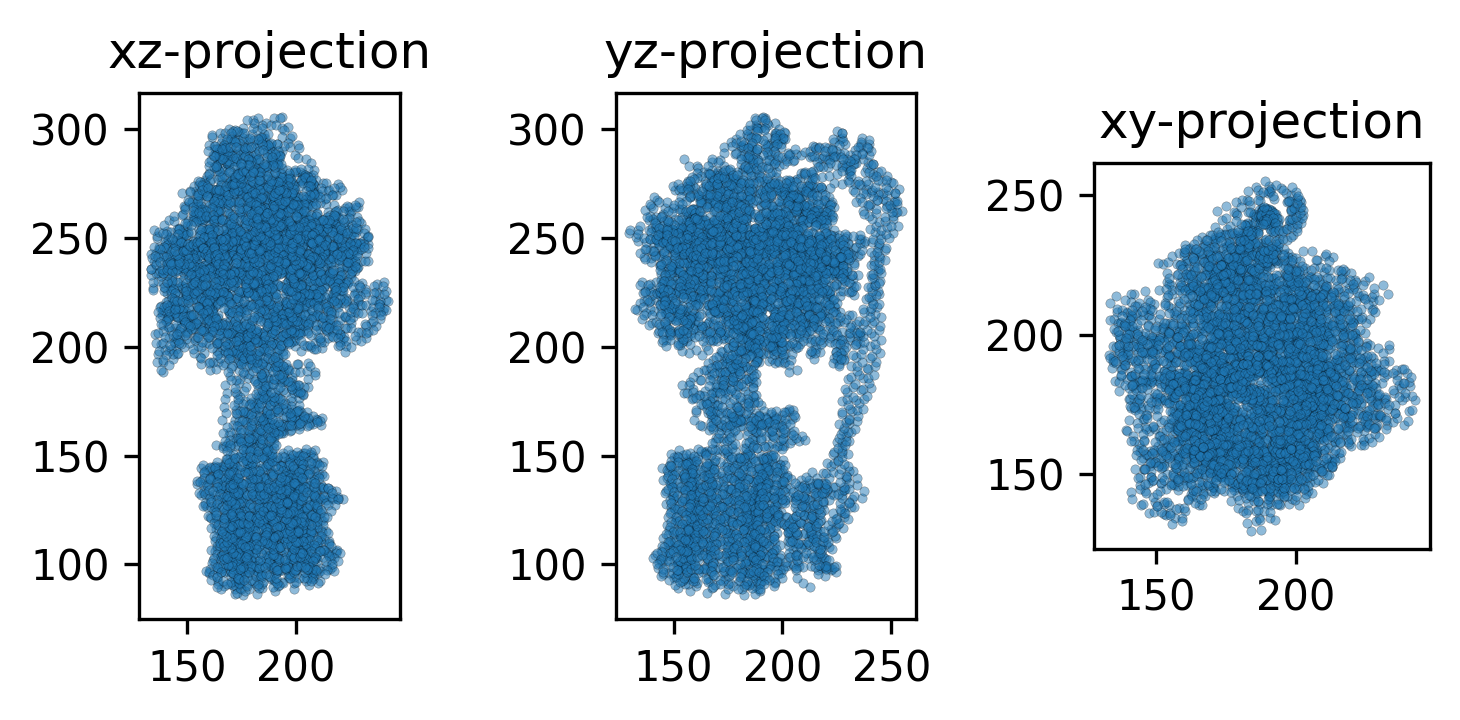

In [2]:
import psa.spatial as spatial
import matplotlib.pyplot as plt
import numpy as np

xyz_r, labels_r = load.coordinates(rel_pps)

fig = plt.figure(figsize=(5, 2.5), dpi=300)
axes = [ fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)]
projections = [[0,2], [1,2], [0,1]]
coords = "xyz"

for ax, proj_ax in zip(axes, projections):
    ax.set_title(coords[proj_ax[0]] + coords[proj_ax[1]] + "-projection")
    ax.scatter(xyz_r[:, proj_ax[0]],
               xyz_r[:, proj_ax[1]],
               marker='o',
               edgecolor='k',
               lw=.1,
               s=5, 
               alpha=.5)
    
    ax.axis('scaled')

plt.tight_layout()

## Sequence alignment

Here the sequences of each structure are aligned to a reference, and the common residues are identified, together with dictionaries that translate the common atoms of each residue into a common labeling

First, we generate the reference sequence for the chains of interest. We then perform sequence alignment and obtain the residues where the sequences are aligned. From this, we generate the dictionaries and the common residue set

In [3]:
import psa.sequence as seq

# Compute
com_res, rel_dict, def_dict = seq.pairwise_alignment(rel_pps, def_pps)

## Spatial alignment

We now spatially align the common residues of the deformed structure to the relaxed structure. It is important to note that, while this alignment and orientation do not affect the non-linear strain tensor invariants, they will affect the linear components, and the rotation angles/axis.

We thus try different alignments: the `align_chains`, in this case, the chain 'a'

In [4]:
align_chains = ['a']

spatial.align_structures(rel_pps,
                         def_pps,
                         align_chains,
                         com_res,
                         rel_dict,
                         def_dict)

## Elasticity calculations

We perform the basic elasticity calculations. We first load the coordinates of the common atoms in the polypeptides, that have by now been aligned spatial and sequence-wise.

In [5]:
rel_xyz, rel_labels = load.coordinates(rel_pps,
                                       com_res,
                                       rel_dict)
def_xyz, def_labels = load.coordinates(def_pps,
                                       com_res,
                                       def_dict)

Using these coordinates, we compute the deformation gradients using the adequate weight function. These are intermediate quantities.

In [6]:
import psa.elastic as elastic

weights = elastic.compute_weights_fast([rel_xyz, def_xyz], 
                                       "intersect",
                                       [10.])

F = elastic.deformation_gradient_fast(weights, rel_xyz, def_xyz)

We can now calculate, the rotations, the strain invariants, and the principal stretches

In [7]:
rot_angle, rot_axis = elastic.rotations(F)
rot_axis = spatial.vector_to_polar(rel_xyz, rot_axis)
gam_l, gam_n = elastic.lagrange_strain(F)
stretches, stretch_axis = elastic.principal_stretches_from_g(gam_n)
stretches_l, _ = elastic.principal_stretches_from_g(gam_l)

## Rotations

### Rotation histogram

We begin by doing some figures relative to the rotations. First, a histogram of the obtained values. We highlight a peak of residues at 103°, which corresponds to the relative rotation found for $F_0$.

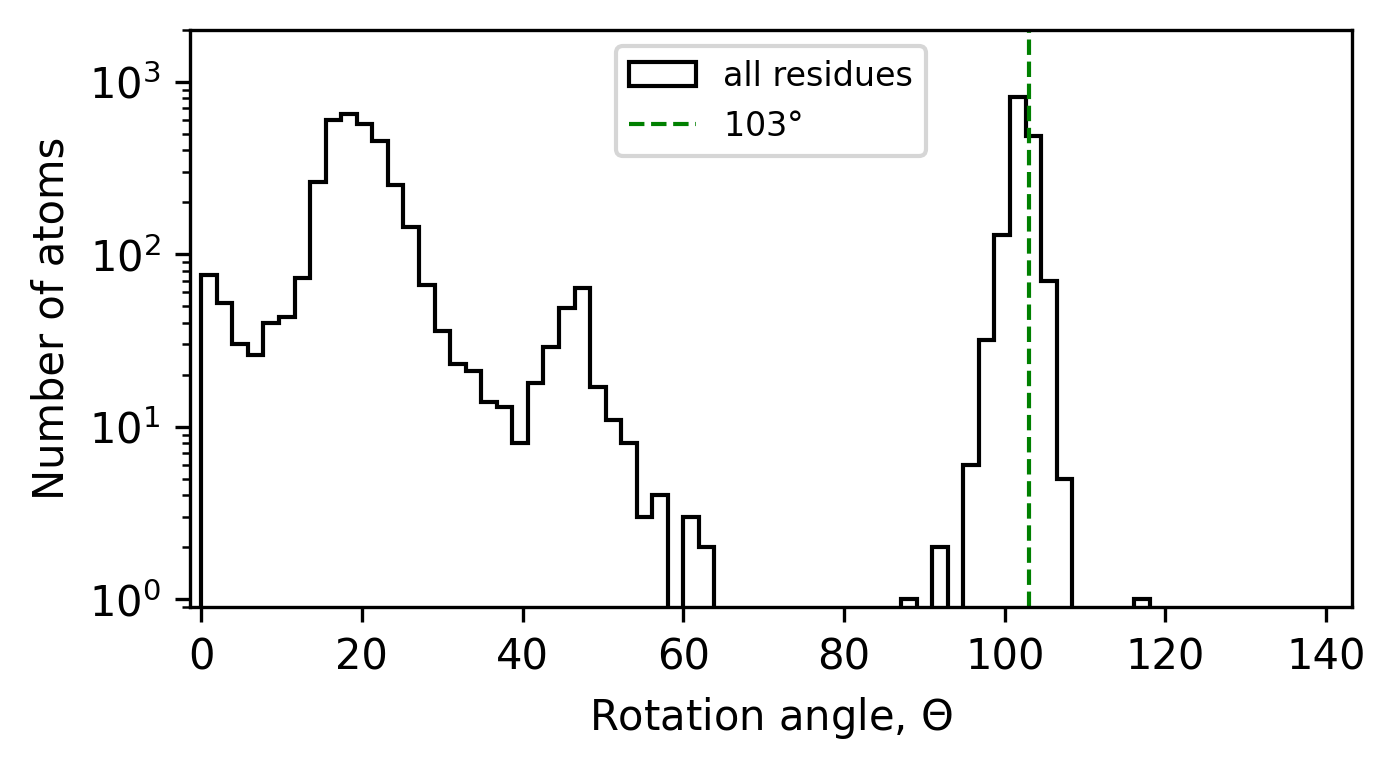

In [8]:
fig = plt.figure(figsize=(5, 2.5), dpi = 300)
ax = fig.add_subplot(111)
x = np.linspace(0., 2.5*180./np.pi, 75)

ax.hist(np.array(rot_angle)*180./np.pi,  x,
        log=False, 
        alpha=1., label='all residues',
        histtype='step', range=(100,1000),
        ec='k',color='lightgray')
    
ax.axvline(103., 0, 1, c='green',
           linestyle='--', linewidth=1.,
           label='$103°$')

ax.legend(loc='upper center', fontsize=8)
ax.set_ylim([.9, 2000.])
ax.set_xlim([-0.025*180./np.pi, 2.5*180./np.pi])
ax.set_xlabel('Rotation angle, $\\Theta$')
ax.set_ylabel('Number of atoms')
ax.set_yscale('log')

plt.show()

### Spatial representation of rotations

We can visualize the magnitude of the rotations in the 3D structure using matplotlib

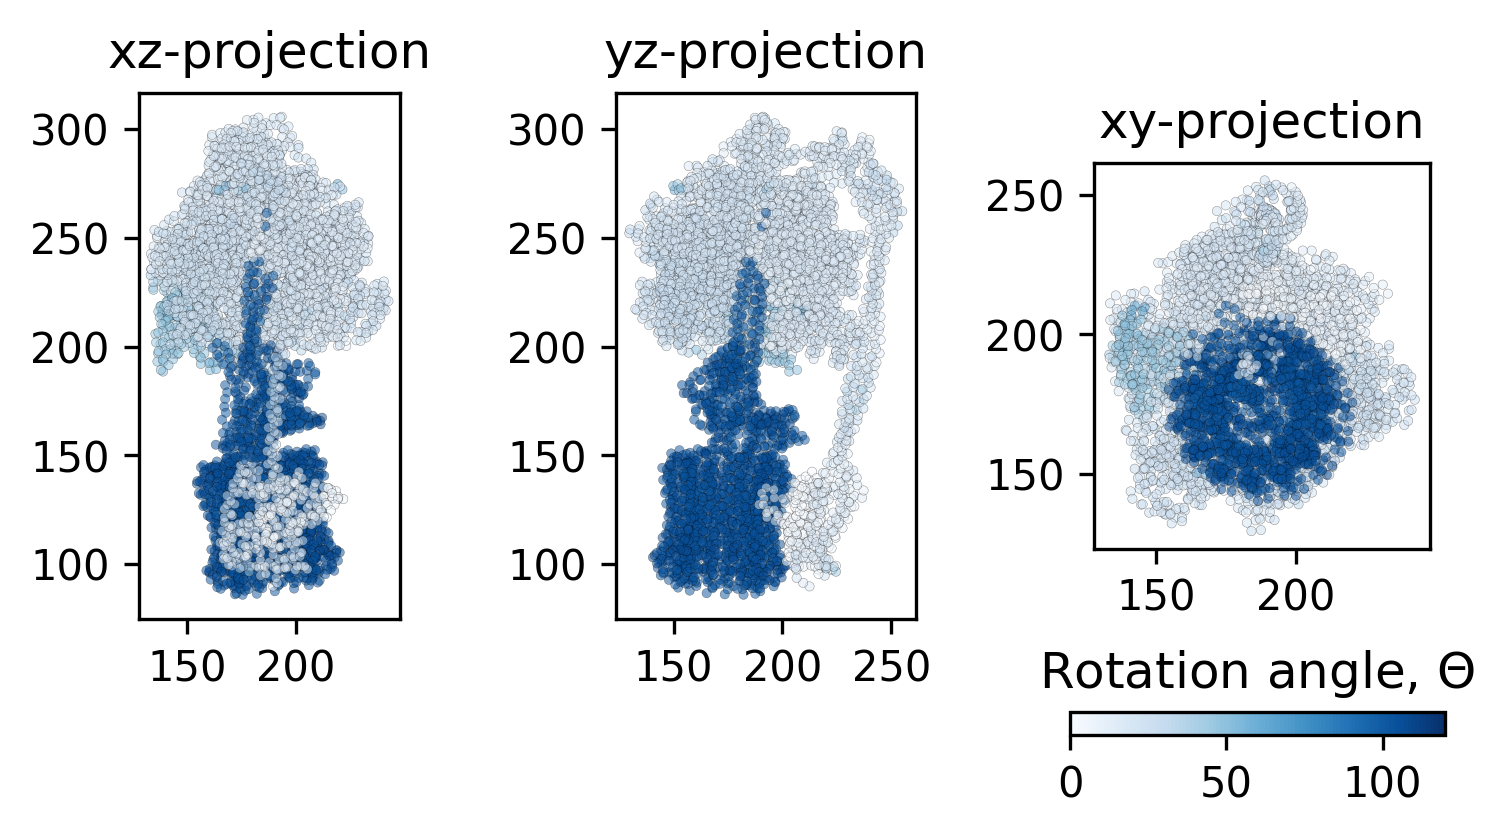

In [9]:
from matplotlib import cm
import matplotlib.colors as colors

fig = plt.figure(figsize=(5, 2.5), dpi=300)
axes = [ fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)]

cmap = cm.get_cmap("Blues", 100)
norm = colors.Normalize(vmin=0, vmax=120)

for ax, proj_ax in zip(axes, projections):
    ax.set_title(coords[proj_ax[0]] + coords[proj_ax[1]] + "-projection")
    ax.scatter(rel_xyz[:, proj_ax[0]],
               rel_xyz[:, proj_ax[1]],
               c=np.array(rot_angle)*180./np.pi,
               cmap=cmap,
               marker='o',
               edgecolor='k',
               lw=.1,
               s=5, 
               alpha=.5)
    
    ax.axis('scaled')

cbar_ax = plt.axes([0.73, 0, 0.25, 0.03])
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                    cax = cbar_ax, orientation='horizontal')
cbar_ax.set_xlim(0, 120)
cbar_ax.set_title("Rotation angle, $\\Theta$")

plt.tight_layout()

### Export rotations to PDB file

If we are happy with the rotation magnitude preview, we can export the labeling to a new PDB file. We replace the information contained in the $\beta$-factor column by the rotation angle in degrees, so the proper color scale settings can be used on any protein visualisation software

In [10]:
angle_dict = {}
for label, angle in zip(rel_labels, np.array(rot_angle)*180./np.pi):
    angle_dict[label[0]] = angle

load.save_bfactor(name=rel_pdb, 
                  bfact=angle_dict,
                  ext='_rot')

## Strain

### Stretch histograms

We begin by analyzing the stretch histograms. As one can see the three stretches separate nicely (a consequence of incompressibility). We observe that there are regions of significant compressions and extensions, and this suggests that the signal is either in the large $\lambda_3$ or in the small $\lambda_1$. 

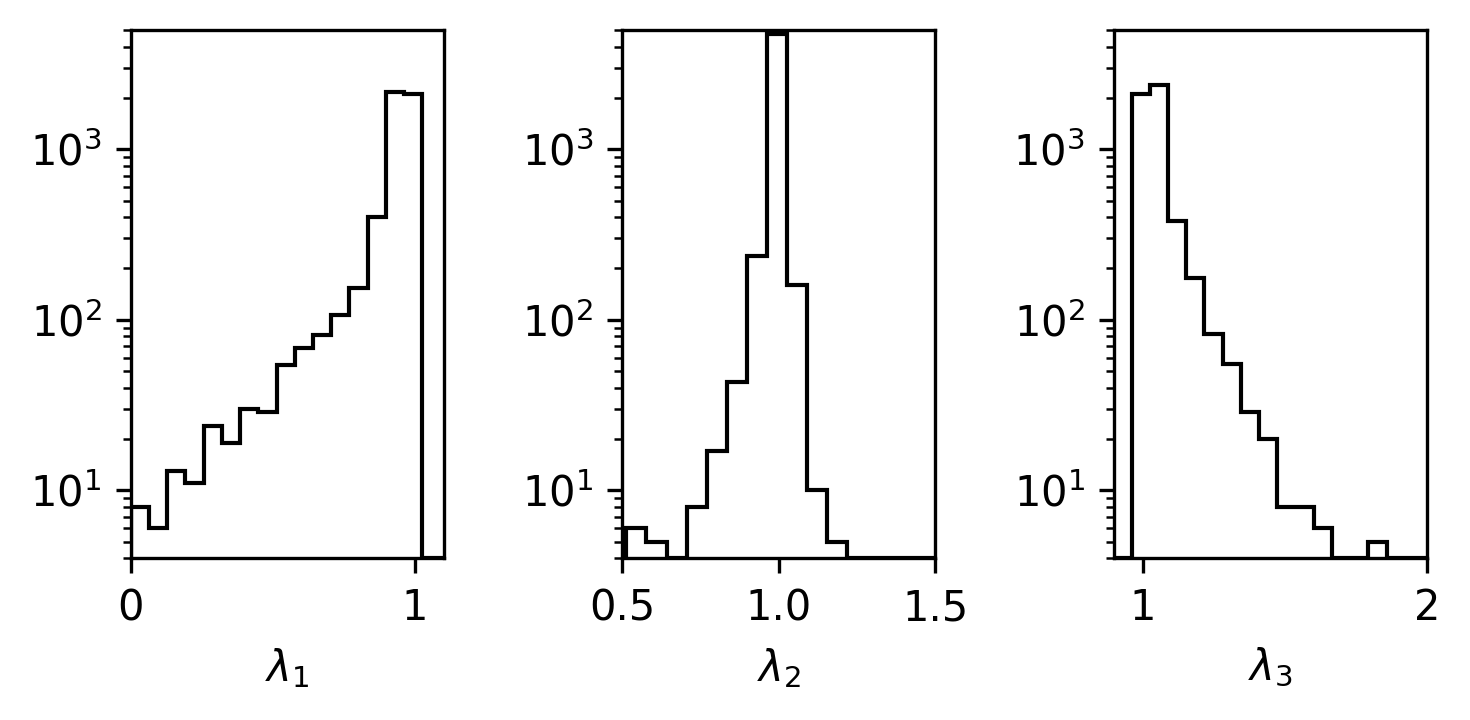

In [11]:
x = np.linspace(0., 2.5, 40)

fig = plt.figure(figsize=(5, 2.5), dpi = 300)
axes = [fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)]
x_ranges = [(0.,1.1),(0.5,1.5),(0.9,2.)]
for ind, ax in enumerate(axes):
    ax.hist(np.sqrt(stretches[:, ind]), x,
             alpha=1., histtype='step', bottom=4,
             ec='k', log=True,
             color='tab:blue')
    ax.set_ylim([4, 5000.])
    ax.set_xlim(x_ranges[ind])
    ax.set_xlabel('$\\lambda_'+str(ind+1)+'$')

plt.tight_layout()

### Spatial representation of strain

We plot the strain identified in the space of stretch axis/strain in real space. Note that the "signal" is now split in two far distant regions. We use the same coloring approach is for the strain-space, quantitative capped by (upper) threshold

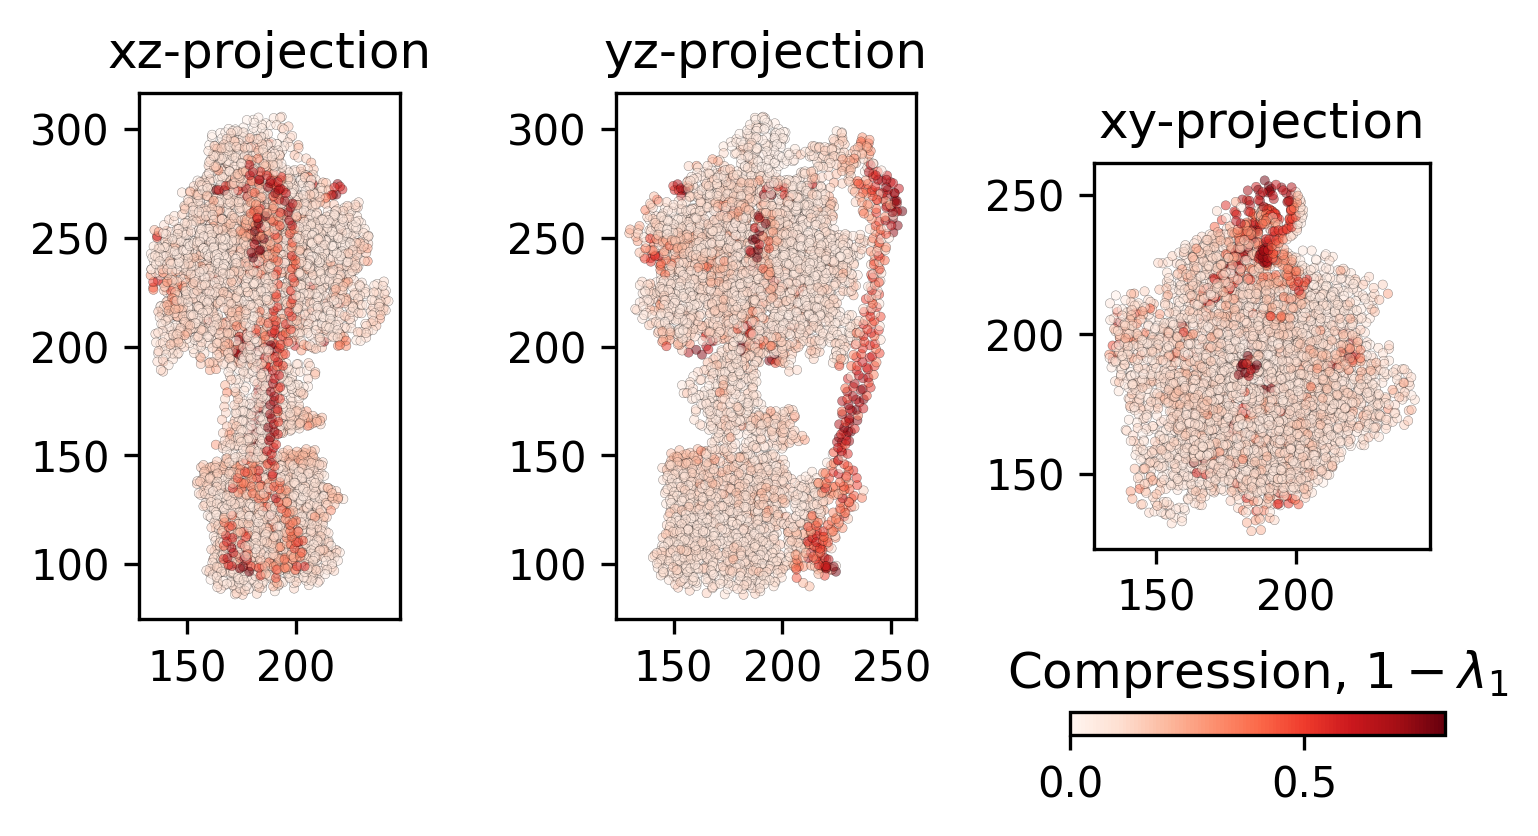

In [12]:
fig = plt.figure(figsize=(5, 2.5), dpi=300)
axes = [fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)]
projections = [[0,2], [1,2], [0,1]]

cmap = cm.get_cmap("Reds", 100)
norm = colors.Normalize(vmin=0, vmax=0.8)

for ax, proj_ax in zip(axes, projections):
    ax.set_title(coords[proj_ax[0]] + coords[proj_ax[1]] + "-projection")
    ax.scatter(rel_xyz[:, proj_ax[0]],
               rel_xyz[:, proj_ax[1]],
               c=1-np.abs(stretches[:, 0]),
               cmap=cmap,
               marker='o',
               edgecolor='k',
               lw=.1,
               s=5, 
               alpha=.5)
    
    ax.axis('scaled')

cbar_ax = plt.axes([0.73, 0, 0.25, 0.03])
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                    cax = cbar_ax, orientation='horizontal')
cbar_ax.set_xlim(0, 0.8)
cbar_ax.set_title("Compression, $1-\lambda_1$")

plt.tight_layout()

### Export strain to PDB files

As we did for the rotation angles, we save the principal stretches in different PDB files.

In [13]:
for i in range(3):
    strain_dict = {}
    for label, st in zip(rel_labels, np.abs(stretches[:, i])):
        strain_dict[label[0]] = st

    load.save_bfactor(name=rel_pdb,
                      bfact=strain_dict,
                      ext='_st_quant_L' + str(i+1))

### Export strain and rotations to text file

In [14]:
var_values = [np.abs(stretches[:, 0]), 
              np.abs(stretches[:, 1]), 
              np.abs(stretches[:, 2]), 
              rot_angle]

load.save_txt(rel_pdb, def_pdb, var_values, rel_labels, "l1-l2-l3-rot")